In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
from numpy import asarray as ar,exp

In [2]:
#  **************    B1128+455     **************
fits_filename = ('/Users/orion/phd_research/blr_fit/1128+455_spec-6647-56390-0206.fits')     
hdul = fits.open(fits_filename)
hdul.info()

Filename: /Users/orion/phd_research/blr_fit/1128+455_spec-6647-56390-0206.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     125   ()      
  1  COADD         1 BinTableHDU     26   4623R x 8C   [E, E, E, J, J, E, E, E]   
  2  SPALL         1 BinTableHDU    474   1R x 232C   [27A, 14A, 4A, E, E, J, J, E, J, E, E, E, K, K, K, K, K, B, B, J, I, 5E, 5E, J, J, J, J, 6A, 6A, 16A, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, 5E, E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 16A, 9A, 12A, E, E, E, E, E, E, E, E, J, E, E, J, J, 6A, 21A, E, 35E, K, 19A, 19A, 19A, B, B, B, I, 3A, B, I, I, I, I, J, E, J, J, E, E, E, E, E, E, E, E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5J, 5J, 5J, 5E, 5J, 75E, 75E, 5E, 5E, 5E, 5J, 5E, D, D, D, D, D, D, D, D, D, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E, 5E,

In [3]:
spec=hdul[0].data
header=hdul[0].header

In [4]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TELESCOP= 'SDSS 2.5-M'         / Sloan Digital Sky Survey                       
FLAVOR  = 'science '           / exposure type, SDSS spectro style              
BOSSVER = '2       '           / ICC version                                    
MJD     =                56390 / APO fMJD day at start of exposure              
MJDLIST = '56390   '           /                                                
NAME    = '6647-56390-01'      / The name of the currently loaded plate         
PLATEID =                 6647 / The currently loaded plate                     
TILEID  =                15569 /Cartridge used in this plugging                 
CARTID  =                   

In [7]:
flux = hdul[1].data['flux']
lam = 10**(hdul[1].data['loglam'])    # wavelength scale is in log

In [8]:
units_flux = hdul[0].header['bunit']
print(units_flux)

1E-17 erg/cm^2/s/Ang


Text(0, 0.5, 'Flux density')

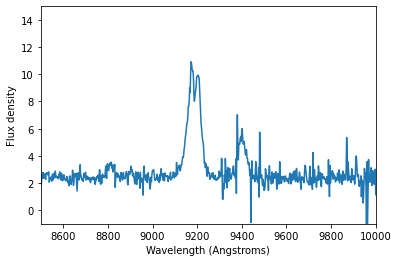

In [9]:
plt.plot(lam, flux)
plt.ylim(-1,15)
plt.xlim(8500,10000)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux density')

In [10]:
# De-redshifting spectrum 

z = 0.397899   #sdss spectroscopic
k = 1+z
k

1.397899

Text(0, 0.5, 'Flux density')

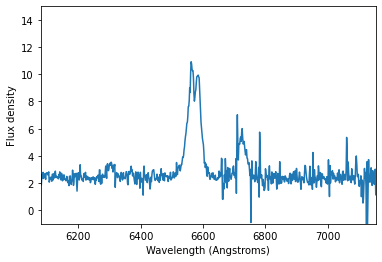

In [11]:
plt.plot(lam/k, flux)
plt.ylim(-1,15)
plt.xlim(8500/k,10000/k)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux density')

In [12]:
# Needs continuum subtraction

In [24]:
select_cont = (lam>8300) & (lam<8700)
continuum = flux[select_cont]

continuum[np.isnan(continuum)] = 1e-15
mean_cont = np.mean(continuum)
mean_cont

-4.65207e-09

In [25]:
flux = flux - mean_cont

In [ ]:
# H-alpha fitting

In [ ]:
select = (lam/k>6200) & (lam/k<7000)
wave = (lam/k)[select]
spec = flux[select]

print (lam/k)
plt.plot(wave,spec,'k-')

In [16]:
# Rest wavelengths of the lines (** should be in VACUUM for SDSS spectra)

#NIIa = 6549.86
#NIIb = 6585.27
#Halpha = 6564.614
#SIIa = 6718.29
#SIIb = 6732.68

In [33]:
def redshift(vel):
    return vel/300000.0 

def line_width(vel_sigma,rest_line,inst_res_fwhm=0.0): 
    sigma = vel_sigma/(300000.0-vel_sigma)*rest_line
    return np.sqrt(sigma**2+(inst_res_fwhm/2.354)**2) 

def gauss(wave_range,amplitude,vel,vel_sigma,rest_w):
    line = (amplitude)*exp(-(wave_range-(rest_w*(1+redshift(vel))))**2/(2*(line_width(vel_sigma, rest_w))**2))
    return line

def full_gauss(wave_range,amp_Ha,amp_NII6585,amp_SII6716,amp_SII6730,vel,vel_sigma,amp_HaB,vel_HaB,vel_sigma_HaB,m,c):#amp_HaBS
    SII_6716 = gauss(wave_range,amp_SII6716,vel,vel_sigma,6718.29)
    SII_6730 = gauss(wave_range,amp_SII6730,vel,vel_sigma,6732.68)
    Ha = gauss(wave_range,amp_Ha,vel,vel_sigma,6564.614)
    Ha_broad = gauss(wave_range,amp_HaB,vel_HaB,vel_sigma_HaB, 6564.614)
    NII_6583 = gauss(wave_range,amp_NII6585,vel,vel_sigma,6585.27)
    NII_6548 = (0.34)*gauss(wave_range,amp_NII6585,vel,vel_sigma,6549.86)
    cont = (wave_range/1000.0)*m+c
    return Ha + Ha_broad + NII_6548 + NII_6583 + SII_6716 + SII_6730 + cont  

[ 5.28209196e+00  5.39540147e+00  2.63341225e+00  2.14482745e+00
 -1.75094398e+01  3.32875061e+02  2.33043080e+00  2.52044359e+02
  1.19661068e+03 -2.14638287e-01  1.42687958e+00]


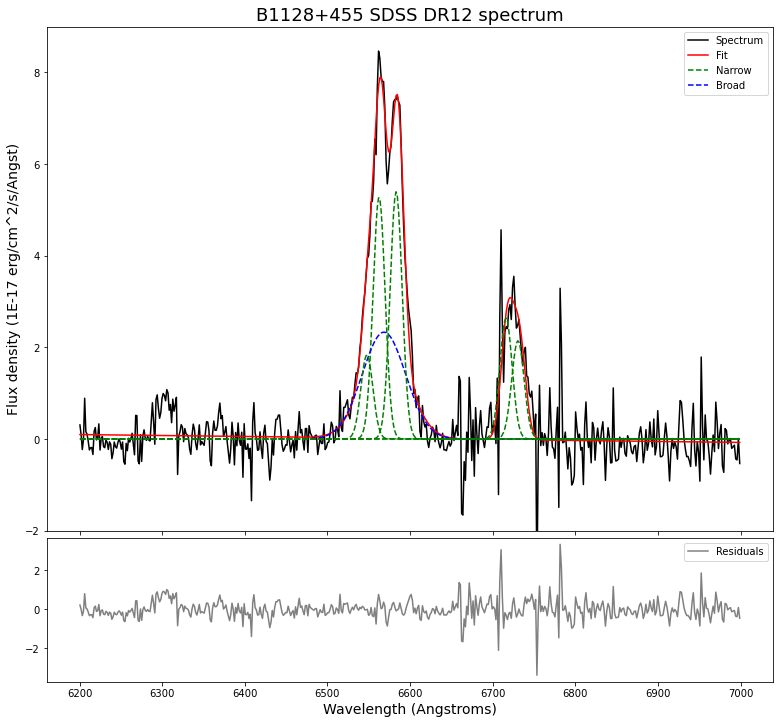

In [42]:
#popt, pcov = curve_fit(func, x, y, p0=[<initial guesses>])
#p0 = [amp_Ha_narrow , amp_NII6585 , amp_SII6716 , amp_SII6730 , vel_narrow , vel_sigma_narrow , amp_Ha_broad , 
#vel_Ha_broad , vel_sigma_Ha_broad , m , c]
#constraint: same linewidths for all narrow components

fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.27, 0.84, 0.7]) # main axes
ax2 = fig.add_axes([0.1, 0.06, 0.84, 0.2]) # inset axes

popt_full_fit,pcov_full_fit = curve_fit(full_gauss, wave, spec, p0=[10, 10, 5, 5, 0, 100, 3, 0, 200, 0, 0])                                                  
print (popt_full_fit)

yfit = full_gauss(wave, *popt_full_fit)
(amp_Ha,amp_NII6585,amp_SII6716,amp_SII6730,vel,vel_sigma,amp_HaB,vel_HaB,vel_sigma_HaB,m,c) = popt_full_fit

ax1.plot(wave, spec, 'k-', label='Spectrum')
ax1.plot(wave, yfit,'r-',label='Fit')
ax1.plot(wave, gauss(wave,amp_Ha,vel,vel_sigma,6562.8), 'g-', linestyle='--', label='Narrow')
ax1.plot(wave, gauss(wave,amp_HaB,vel_HaB,vel_sigma_HaB, 6562.8), 'b-', linestyle='--', label='Broad')
ax1.plot(wave, gauss(wave,amp_NII6585,vel,vel_sigma,6583.46), 'g-', linestyle='--')
ax1.plot(wave, (0.34)*gauss(wave,amp_NII6585,vel,vel_sigma,6548.05), 'g-', linestyle='--')
ax1.plot(wave, gauss(wave,amp_SII6716,vel,vel_sigma,6716.4), 'g-', linestyle='--')
ax1.plot(wave, gauss(wave,amp_SII6730,vel,vel_sigma,6730.8), 'g-', linestyle='--')
residuals = spec - yfit
ax2.plot(wave, residuals, 'gray', label='Residuals')
plt.rcParams["figure.figsize"] = [12,10]
ax1.set_title('B1128+455 SDSS DR12 spectrum', {'fontsize': 18})
ax1.set_ylabel('Flux density (1E-17 erg/cm^2/s/Angst)', {'fontsize': 14})
ax2.set_ylabel('Residuals', {'fontsize': 14})
ax2.set_xlabel('Wavelength (Angstroms)', {'fontsize': 14})
ax1.set_ylim(-2,9)
ax1.legend()
ax2.legend()
plt.show()

In [35]:
perr_full_fit = np.sqrt(np.diag(pcov_full_fit))
perr_full_fit

array([7.44561474e-01, 6.75793360e-01, 2.32172714e-01, 2.33345125e-01,
       1.81829450e+01, 1.97466357e+01, 8.89222350e-01, 8.98362981e+01,
       1.78622075e+02, 9.71288584e-02, 6.40323878e-01])

In [ ]:
# Gives convergence error without Ha broad component:
#     OptimizeWarning: Covariance of the parameters could not be estimated (category=OptimizeWarning)

In [49]:
# component-flux computations

sigma_eff_HaB = line_width(vel_sigma_HaB,6564.614)
broadline_flux = amp_HaB*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_HaB))#*(10**(-17))
print('broad:', broadline_flux, '(x1E-17)')

broad: 153.56869507062927 (x1E-17)


In [50]:
sigma_eff_Ha = line_width(vel_sigma,6564.614)
narrowline_flux = amp_Ha*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Ha))#*(10**(-17))
print('narrow:', narrowline_flux, '(x1E-17)')

narrow: 96.54888091386609 (x1E-17)


In [ ]:
# H-beta fitting  

In [ ]:
select2 = (lam/k>4500) & (lam/k<7000)
wave2 = (lam/k)[select2]
spec2 = flux[select2]

print (lam/k)
plt.plot(wave2,spec2,'k-')

In [56]:
def gauss(wave_range,amplitude,vel,vel_sigma,rest_w):
    line = (amplitude)*exp(-(wave_range-(rest_w*(1+redshift(vel))))**2/(2*(line_width(vel_sigma, rest_w))**2))
    return line

def full_gauss2(wave_range,amp_Ha,amp_Hb,amp_NII6585,amp_SII6716,amp_SII6730,vel,vel_sigma,amp_HaB,vel_HaB,vel_sigma_HaB,m,c):#amp_HaBS
    SII_6716 = gauss(wave_range,amp_SII6716,vel,vel_sigma,6718.29)
    SII_6730 = gauss(wave_range,amp_SII6730,vel,vel_sigma,6732.68)
    Ha = gauss(wave_range,amp_Ha,vel,vel_sigma,6564.614)
    Ha_broad = gauss(wave_range,amp_HaB,vel_HaB,vel_sigma_HaB, 6564.614)
    H_beta = gauss(wave_range,amp_Hb,vel,vel_sigma, 4862.721)
    NII_6583 = gauss(wave_range,amp_NII6585,vel,vel_sigma,6585.27)
    NII_6548 = (0.34)*gauss(wave_range,amp_NII6585,vel,vel_sigma,6549.86)
    cont = (wave_range/1000.0)*m+c
    return Ha + Ha_broad + NII_6548 + NII_6583 + SII_6716 + SII_6730 + H_beta + cont  

[ 5.25828845e+00  5.51446049e-01  5.35599750e+00  2.65484263e+00
  2.18697320e+00 -2.05885413e+01  3.29357162e+02  2.42592613e+00
  2.60112026e+02  1.20127765e+03 -1.46251663e-01  9.54263261e-01]


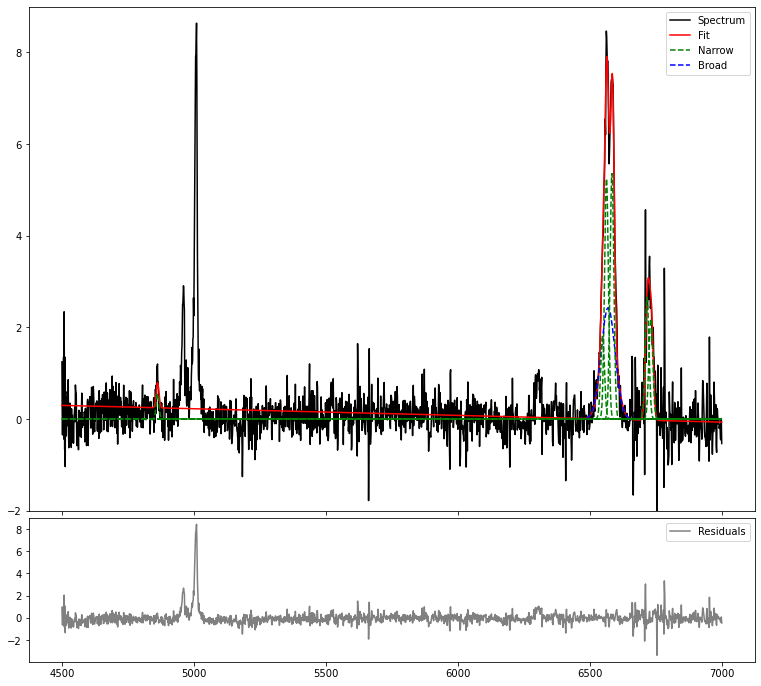

In [60]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.27, 0.84, 0.7]) # main axes
ax2 = fig.add_axes([0.1, 0.06, 0.84, 0.2]) # inset axes

popt_full_fit,pcov_full_fit = curve_fit(full_gauss2, wave2, spec2, p0=[10, 2, 10, 5, 5, 0, 100, 3, 0, 200, 0, 0])                                                  
print (popt_full_fit)

yfit = full_gauss2(wave2, *popt_full_fit)
(amp_Ha,amp_Hb,amp_NII6585,amp_SII6716,amp_SII6730,vel,vel_sigma,amp_HaB,vel_HaB,vel_sigma_HaB,m,c) = popt_full_fit

ax1.plot(wave2, spec2, 'k-', label='Spectrum')
ax1.plot(wave2, yfit,'r-',label='Fit')
ax1.plot(wave2, gauss(wave2,amp_Ha,vel,vel_sigma,6562.8), 'g-', linestyle='--', label='Narrow')
ax1.plot(wave2, gauss(wave2,amp_HaB,vel_HaB,vel_sigma_HaB, 6562.8), 'b-', linestyle='--', label='Broad')
ax1.plot(wave2, gauss(wave2,amp_NII6585,vel,vel_sigma,6583.46), 'g-', linestyle='--')
ax1.plot(wave2, (0.34)*gauss(wave2,amp_NII6585,vel,vel_sigma,6548.05), 'g-', linestyle='--')
ax1.plot(wave2, gauss(wave2,amp_SII6716,vel,vel_sigma,6716.4), 'g-', linestyle='--')
ax1.plot(wave2, gauss(wave2,amp_SII6730,vel,vel_sigma,6730.8), 'g-', linestyle='--')
ax1.plot(wave2, gauss(wave2,amp_Hb,vel,vel_sigma,4862.721), 'g-', linestyle='--')
residuals = spec2 - yfit
ax2.plot(wave2, residuals, 'gray', label='Residuals')
plt.rcParams["figure.figsize"] = [12,10]
#ax1.set_title('B1128+455 SDSS DR12 spectrum', {'fontsize': 18})
#ax1.set_ylabel('Flux density (1E-17 erg/cm^2/s/Angst)', {'fontsize': 14})
#ax2.set_ylabel('Residuals', {'fontsize': 14})
#ax2.set_xlabel('Wavelength (Angstroms)', {'fontsize': 14})
ax1.set_ylim(-2,9)
ax1.legend()
ax2.legend()
plt.show()

In [61]:
sigma_eff_Hb = line_width(vel_sigma, 4862.721)
narrow_Hb_flux = amp_Hb*(np.sqrt(2.*np.pi)*np.fabs(sigma_eff_Hb))#*(10**(-17))
print('Hb:', narrow_Hb_flux, '(x1E-17)')

Hb: 7.387461466252447 (x1E-17)
